# Amazon Fine Food Review Sentiment Prediction

# Data Definition
Data - https://www.kaggle.com/snap/amazon-fine-food-reviews

Context

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Contents

Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite
database.sqlite: Contains the table 'Reviews'

Data includes:

Reviews from Oct 1999 - Oct 2012

568,454 reviews
256,059 users
74,258 products
260 users with > 50 reviews

# Column Definition

Id-Row Id

ProductId-Unique identifier for the product

UserId-Unqiue identifier for the user

ProfileName-Profile name of the user

HelpfulnessNumerator-Number of users who found the review helpful

HelpfulnessDenominator-Number of users who indicated whether they found the review helpful or not

Score-Rating between 1 and 5

Time-Timestamp for the review

Summary-Brief summary of the review

Text-Text of the review

## PREDICT WHETHER REVIEW IS POSITIVE OR NEGATIVE

In [2]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.naive_bayes import BernoulliNB
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from gensim.models import KeyedVectors
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
import gc
from sklearn.linear_model import LogisticRegression
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [2]:
con = sqlite3.connect("D:/Datasets/Amazon Fine Food Reviews/database.sqlite")

In [3]:
data = pd.read_sql_query("select * from reviews where score!=3", con)

In [4]:
def partition(x):
    if x>3:
        return 1
    else:
        return 0

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Change score to binary values

In [6]:
data.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [7]:
data.shape

(525814, 10)

In [8]:
scores = data['Score']

In [9]:
actual_scores = scores.map(partition)

In [10]:
data['Score'] = actual_scores

In [11]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning

1 User reviewing with same text and time, even if productIds are different meaning products are correlated and not separate

Thus, these extra rows must be removed

In [12]:
data.drop_duplicates(subset=['UserId', 'Text','Time'], inplace = True)

In [13]:
data.shape

(364133, 10)

Numerator cannot be less than denominaton

In [14]:
data = data[data['HelpfulnessNumerator']<=data['HelpfulnessDenominator']]

In [15]:
data.shape

(364131, 10)

In [16]:
data.drop_duplicates(subset=['UserId', 'Time'], inplace=True)

In [17]:
data.shape

(328731, 10)

# Preprocessing for Models

We will now remove extra columns that will not affect the Score in any way

We only need Text and score values

In [18]:
data.drop(['ProductId', 'UserId','ProfileName','Time'], axis=1, inplace=True)

In [19]:
data.head()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,1,1,1,1,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0,0,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,1,1,1,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,3,3,0,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0,0,1,Great taffy,Great taffy at a great price. There was a wid...


In [20]:
data.drop(['Id','HelpfulnessNumerator','HelpfulnessDenominator'], axis=1, inplace=True)

In [21]:
data.drop('Summary', inplace=True, axis=1)

In [22]:
data.head()

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


# Feature Engineering to form vectors from words

We will use 2 techniques of feature engineering - 
1. Bag of Words
2. Average Word2Vec

## Basic Preprocessing - 
1. Remove HTML tags
2. Remove punctuation

In [23]:
def cleanText(sentence):
    html = re.compile('<.*?>')
    cleantext = re.sub(html,' ', sentence)
    punctuation = re.compile('[?|!|\'|"|#|.|,|(|)|\|/]')
    cleantext = re.sub(punctuation,' ', sentence)
    return cleantext.lower()

In [24]:
data['Text']=data['Text'].map(cleanText)

In [25]:
data.head()

,Score,Text
0,1,i have bought several of the vitality canned d...
1,0,product arrived labeled as jumbo salted peanut...
2,1,this is a confection that has been around a fe...
3,0,if you are looking for the secret ingredient i...
4,1,great taffy at a great price there was a wid...


# Bag of Words

### Pre processing for BOW :
1. Removal of stop words
2. Stemming using Snowball Stemmer
3. BOW

### Removal of stop words

In [27]:
BOW_Text = []

stop = set(stopwords.words('english'))

stemmer=SnowballStemmer('english')

In [28]:
data.head()

,Score,Text
0,1,i have bought several of the vitality canned d...
1,0,product arrived labeled as jumbo salted peanut...
2,1,this is a confection that has been around a fe...
3,0,if you are looking for the secret ingredient i...
4,1,great taffy at a great price there was a wid...


### Stemming using SnowballStemmer

In [29]:
for k in data['Text'].values:
    filtered_sentence = []
    k = cleanText(k).split()
    for x in k:
        if x.isalpha() and len(x)>2 and x not in stop:
            j = (stemmer.stem(x).encode('utf8'))
            filtered_sentence.append(j)
    full_sentence = b" ".join(filtered_sentence)
    
    BOW_Text.append(full_sentence)
    

In [30]:
data['BOW_text'] = BOW_Text

data.to_csv("BOW_data.csv")

In [31]:
vectorizer = CountVectorizer(binary=True)

### Converting data to bag of words using CountVectorizer

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data['BOW_text'], data['Score'], test_size=0.2, random_state=42)
X_train, X_cross, y_train, y_cross = train_test_split(X_train, y_train, test_size=0.1, random_state=4)

In [33]:
training_model = vectorizer.fit_transform(X_train)
cross_validation_model = vectorizer.transform(X_cross)
test_model = vectorizer.transform(X_test)

In [37]:
bernoulli_BOW_model = GridSearchCV(BernoulliNB(), param_grid={'alpha':[1,2,3,4]}, n_jobs=-1, verbose=1, cv=3).fit(training_model,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [39]:
log_BOW_model = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}, n_jobs=-1, verbose=1, cv=3).fit(training_model,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [41]:
xgb_BOW_model = GridSearchCV(XGBClassifier(), param_grid={"n_estimators" : [100,200,400], 'max_depth':[1,2,3] }, n_jobs=-1, verbose=2, cv=3).fit(training_model,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\users\nikch\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [16]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0)) 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [52]:
list_of_bow_models = [bernoulli_BOW_model, log_BOW_model, xgb_BOW_model]
name_bow_models = ['BernoulliNB', 'Logistic Regression', 'XGboost']

In [76]:
train_acc = [accuracy_score(y_train, model.predict(training_model)) for model in list_of_bow_models]
train_acc = [float("{0:0.4f}".format(i)) for i in train_acc]
cross_acc = [accuracy_score(y_cross, model.predict(cross_validation_model)) for model in list_of_bow_models]
cross_acc = [float("{0:0.4f}".format(i)) for i in cross_acc]
test_acc = [accuracy_score(y_test, model.predict(test_model)) for model in list_of_bow_models]
test_acc = [float("{0:0.4f}".format(i)) for i in test_acc]

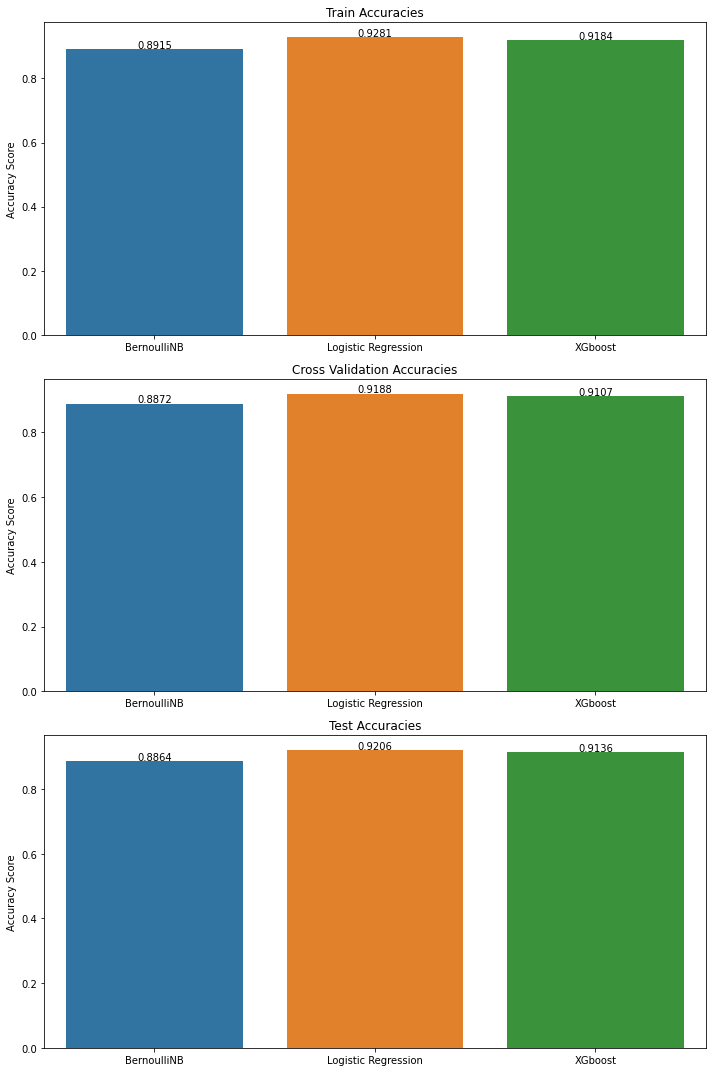

In [108]:
fig = plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
ax1 = sns.barplot(x=name_bow_models, y=train_acc)
plt.title("Train Accuracies")
plt.ylabel("Accuracy Score")
for i in range(0,3):
    ax1.text(i,train_acc[i]+0.004, str(train_acc[i]), ha='center')

plt.subplot(3,1,2)
ax2 = sns.barplot(x=name_bow_models, y=cross_acc)
plt.title("Cross Validation Accuracies")
plt.ylabel("Accuracy Score")
for i in range(0,3):
    ax2.text(i,cross_acc[i]+0.004, str(cross_acc[i]), ha='center')

plt.subplot(3,1,3)
ax3 = sns.barplot(x=name_bow_models, y=test_acc)
plt.title("Test Accuracies")
plt.ylabel("Accuracy Score")
for i in range(0,3):
    ax3.text(i,test_acc[i]+0.004, str(test_acc[i]), ha='center')
plt.tight_layout()
plt.savefig('BOW_accuracies.jpg')

****************************************************************************************************
Model Name: BernoulliNB
Model Parameters: {'alpha': 1}
Confusion matrix for Test Data: 


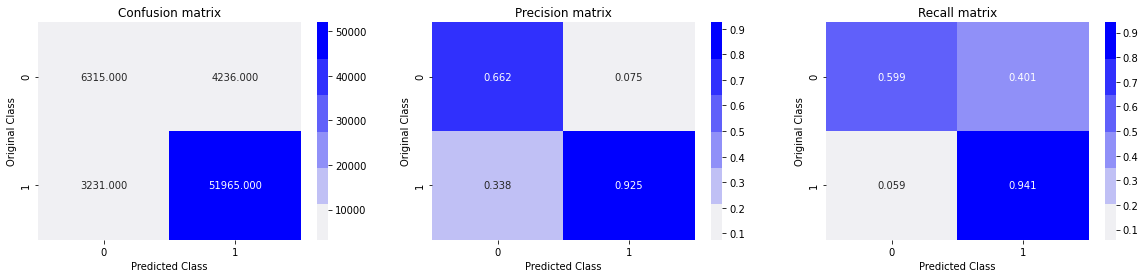

****************************************************************************************************
Model Name: Logistic Regression
Model Parameters: {'C': 0.1}
Confusion matrix for Test Data: 


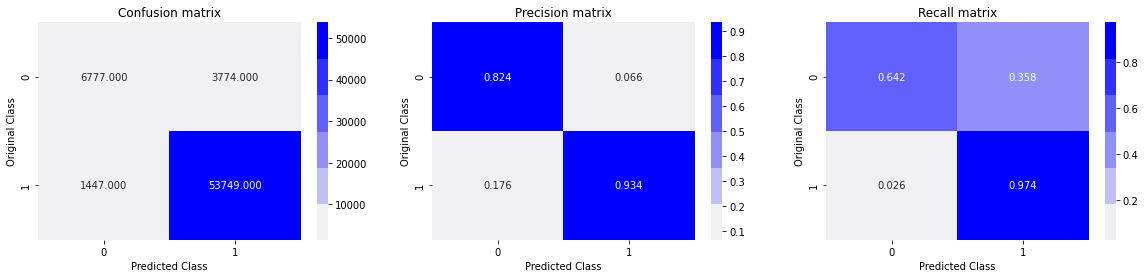

****************************************************************************************************
Model Name: XGboost
Model Parameters: {'max_depth': 3, 'n_estimators': 400}
Confusion matrix for Test Data: 


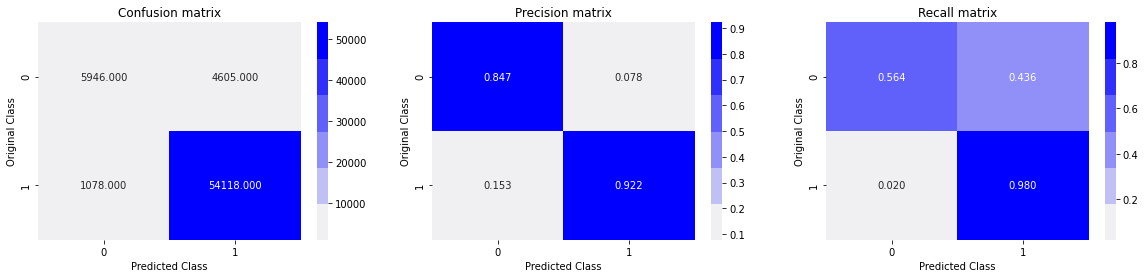

****************************************************************************************************


In [104]:
for i,model in enumerate(list_of_bow_models):
    print("*"*100)
    print("Model Name: " + name_bow_models[i])
    print("Model Parameters: "+ str(model.best_params_))
    print("Confusion matrix for Test Data: ")
    plot_confusion_matrix(y_test, model.predict(test_model))
print("*"*100)

We compare the accuracies of 3 models using Average Word2Vec approach - Bernoilli Naive Bayes (alpha = 1), Logistic Regression (C = 0.1) and XGBoost (max_depth=3, n_estimators=400)
<br>

Out of the 3 models, it appears that XGBoost and Logisitic Regression perform equally well. The models have significantly high accuracy, precision and recall. The accuracies for train, test and cross-validation are close enough to indicate their is no overfitting on the train data.

# Avg Word2Vec

## Using google news vectors as our word2vec model

In [27]:
Word2Vec_model = KeyedVectors.load_word2vec_format('D:/Datasets/GoogleNews-vectors-negative300.bin', binary=True)

In [28]:
Sum_arrays_list = []

for i in data['Text'].values:
    number_of_words = 0
    sum_array = np.zeros(300)
    for k in i:
        try:
            word_vector = Word2Vec_model.get_vector(k)
            sum_array+=word_vector
            number_of_words+=1
        except:
            continue
        sum_array/=number_of_words
        
    Sum_arrays_list.append(sum_array)

In [29]:
word2vec_frame = pd.DataFrame(Sum_arrays_list)

In [31]:
del Sum_arrays_list, Word2Vec_model
gc.collect();

In [80]:
frame = pd.merge(word2vec_frame, data['Score'], left_on=word2vec_frame.index, right_on=data['Score'].index)
frame = frame.drop('key_0', axis=1)

In [86]:
del word2vec_frame
gc.collect();

### Forming training, cross validation and test sets using train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(frame.drop('Score', axis=1), frame['Score'], test_size=0.2, random_state=42)

In [7]:
X_train, X_cross, y_train, y_cross = train_test_split(X_train, y_train, test_size=0.1, random_state=4)

### Scaling our vectors for best effect

In [8]:
scale = StandardScaler()
X_train, X_cross = scale.fit_transform(X_train), scale.transform(X_cross)

In [9]:
logmodel_w2v = GridSearchCV(LogisticRegression(solver='liblinear', class_weight='balanced'), param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}, n_jobs=-1, cv=3).fit(X_train,y_train)

In [10]:
svc_w2v = GridSearchCV(SGDClassifier(class_weight='balanced'), param_grid={'alpha':[0.001, 0.01, 0.1, 1, 10]}, n_jobs=-1, cv=3).fit(X_train,y_train)

In [11]:
xgb_w2v = GridSearchCV(XGBClassifier(tree_method='hist', scale_pos_weight=0.2), param_grid={"n_estimators" : [100,200,400], 'max_depth':[1,2,3] }, n_jobs=-1, cv=3, scoring='f1_micro').fit(X_train,y_train)

[18:22:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [12]:
list_of_w2v_models = [svc_w2v, logmodel_w2v, xgb_w2v]
name_w2v_models = ['Support Vector Classifier', 'Logistic Regression', 'XGboost']

In [13]:
train_acc = [accuracy_score(y_train, model.predict(scale.transform(X_train))) for model in list_of_w2v_models]
train_acc = [float("{0:0.4f}".format(i)) for i in train_acc]
cross_acc = [accuracy_score(y_cross, model.predict(scale.transform(X_cross))) for model in list_of_w2v_models]
cross_acc = [float("{0:0.4f}".format(i)) for i in cross_acc]
test_acc = [accuracy_score(y_test, model.predict(scale.transform(X_test))) for model in list_of_w2v_models]
test_acc = [float("{0:0.4f}".format(i)) for i in test_acc]

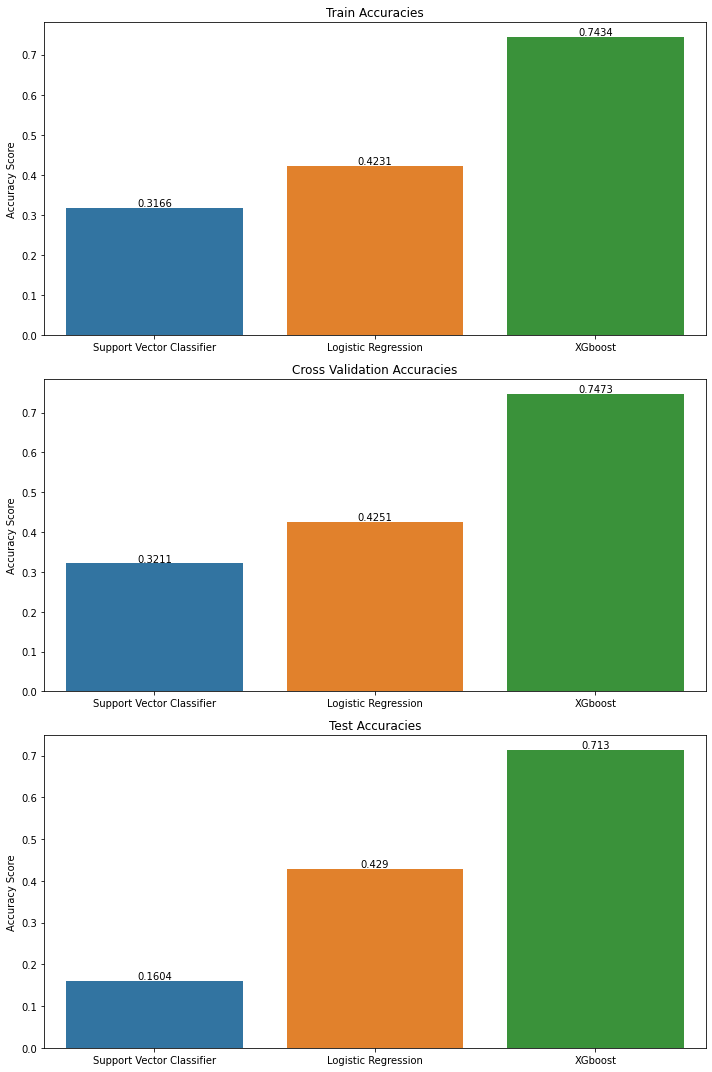

In [14]:
fig = plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
ax1 = sns.barplot(x=name_w2v_models, y=train_acc)
plt.title("Train Accuracies")
plt.ylabel("Accuracy Score")
for i in range(0,3):
    ax1.text(i,train_acc[i]+0.004, str(train_acc[i]), ha='center')

plt.subplot(3,1,2)
ax2 = sns.barplot(x=name_w2v_models, y=cross_acc)
plt.title("Cross Validation Accuracies")
plt.ylabel("Accuracy Score")
for i in range(0,3):
    ax2.text(i,cross_acc[i]+0.004, str(cross_acc[i]), ha='center')

plt.subplot(3,1,3)
ax3 = sns.barplot(x=name_w2v_models, y=test_acc)
plt.title("Test Accuracies")
plt.ylabel("Accuracy Score")
for i in range(0,3):
    ax3.text(i,test_acc[i]+0.004, str(test_acc[i]), ha='center')
plt.tight_layout()
plt.savefig('W2V_accuracies.jpg')

****************************************************************************************************
Model Name: Support Vector Classifier
Model Parameters: {'alpha': 10}
Confusion matrix for Test Data: 


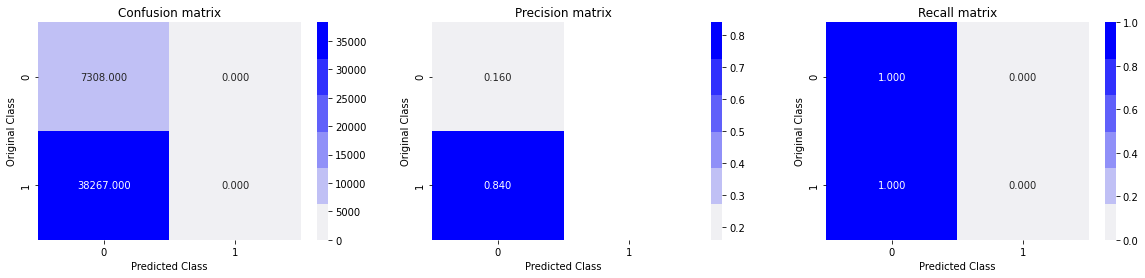

****************************************************************************************************
Model Name: Logistic Regression
Model Parameters: {'C': 0.001}
Confusion matrix for Test Data: 


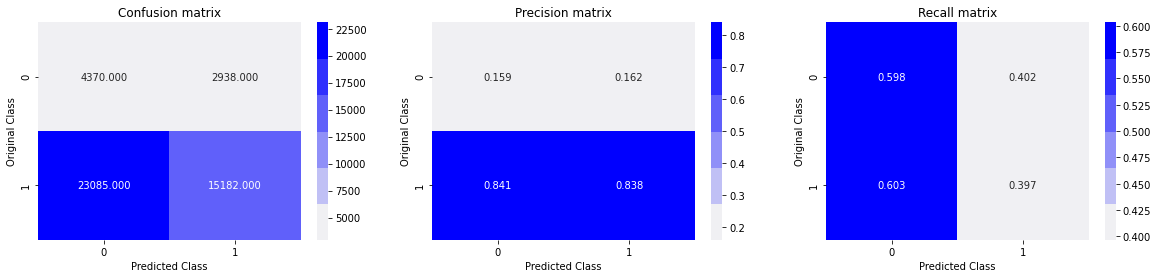

****************************************************************************************************
Model Name: XGboost
Model Parameters: {'max_depth': 1, 'n_estimators': 100}
Confusion matrix for Test Data: 


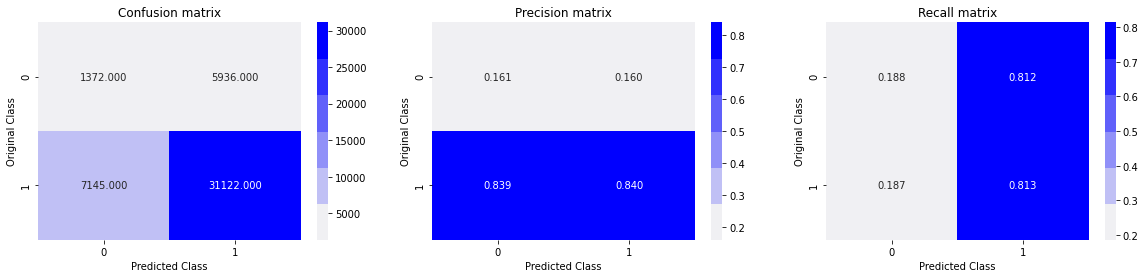

****************************************************************************************************


In [18]:
for i,model in enumerate(list_of_w2v_models):
    print("*"*100)
    print("Model Name: " + name_w2v_models[i])
    print("Model Parameters: "+ str(model.best_params_))
    print("Confusion matrix for Test Data: ")
    plot_confusion_matrix(y_test, model.predict(scale.transform(X_test)))
print("*"*100)

We compare the accuracies of 3 models using Average Word2Vec approach - SVC (alpha = 10), Logistic Regression (C = 0.001) and XGBoost (max_depth=1, n_estimators=100)
<br>

Out of the 3 models, it appears that XGBoost performs best. The model has significantly higher accuracy, precision and recall. The accuracies for train, test and cross-validation are close enough to indicate their is no overfitting 

## Comparison of Feature Engineering Techniques
The Average Word2Vec approach is clearly the worse option of the 2. Bag of Words does not only provide better results, it is also easier to understand and process. The Avg Word2Vec model used takes upto 6-8 GB of RAM and requires higher processing power to train and the case is quite opposite in the Bag of Words approach.